In [ ]:
!nvidia-smi

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, precision_score, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import random
import os
import helper_functions as hf

In [4]:
data = pd.read_excel("../../fake_news_covid.xlsx")
data = data[["label_text", "text"]]
dataF = data[data.label_text=="F"][0:500]
dataT = data[data.label_text=="T"][0:500]
dataU = data[data.label_text=="U"][0:500]
data = pd.concat([dataF, dataT, dataU])
len(data)
data["label_text"].value_counts()
data = data.sample(frac=1).reset_index(drop=True)
print(len(data))
data["text"] = data["text"].str.replace('\n', ' ')
data["label"] = data["label_text"].astype('category')
data["label"] = data["label"].cat.codes
print(data["label"].value_counts())

1500
1    500
2    500
0    500
Name: label, dtype: int64


     1,500 comments
   Min length: 7 tokens
   Max length: 185 tokens
Median length: 24.0 tokens
2 of 1,500 sentences (0.1%) in the training set are longer than 160 tokens.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


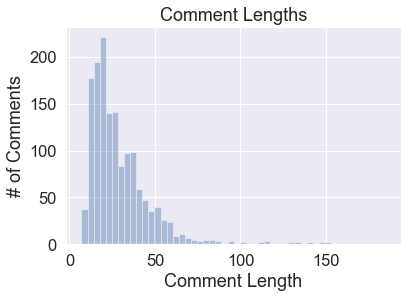

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased", do_lower_case=True)

input_ids = []
lengths = []
for x, row in data.iterrows():
    encoded_sent = tokenizer.encode(
                        row['text'],                      
                        add_special_tokens = True,
                   )
    input_ids.append(encoded_sent)
    lengths.append(len(encoded_sent))

print('{:>10,} comments'.format(len(input_ids)))
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

hf.plot_distribution(lengths)

max_len = 160 #max(lengths)

num_truncated = np.sum(np.greater(lengths, max_len))
num_sentences = len(lengths)
prcnt = float(num_truncated) / float(num_sentences)
print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than {:} tokens.'.format(num_truncated, num_sentences, prcnt, max_len))

# create tokenized data
labels = []
input_ids = []
attn_masks = []

for x, row in data.iterrows():
    encoded_dict = tokenizer.encode_plus(row['text'],
                                              max_length=max_len, #see other code for how to set this
                                              padding='max_length',
                                              truncation=True,
                                              return_tensors='pt')
    input_ids.append(encoded_dict['input_ids'])
    attn_masks.append(encoded_dict['attention_mask'])
    labels.append(row['label'])


# Convert into tensor matrix.
input_ids = torch.cat(input_ids, dim=0)
attn_masks = torch.cat(attn_masks, dim=0)

# Labels list to tensor.
labels = torch.tensor(labels)

# Create TensorDataset.
dataset = TensorDataset(input_ids, attn_masks, labels)

In [5]:
#########
# Specify key model parameters here: 
model_name = "bert-large-uncased"
lr = 3e-5
epochs = 5
batch_size = 32
#########

In [6]:
seed_val = 6
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.cuda.empty_cache() #Clear GPU cache if necessary

training_stats = [] # Store training and validation loss,validation accuracy, and timings.
fold_stats = []

total_t0 = time.time() # Measure the total training time

In [ ]:
# ======================================== #
#              CV Training                 #
# ======================================== #
  
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H%M')

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    train_dataloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
    test_dataloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler)
    
    # Initiate model parameters for each fold
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
    device = torch.device('cuda:0')
    desc = model.to(device)
    optimizer = AdamW(model.parameters(), lr = lr, eps = 1e-6) 
    total_steps = (int(len(dataset)/batch_size)+1) * epochs 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 10, num_training_steps = total_steps)
          
    # Run the training loop for defined number of epochs
    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        t0 = time.time()
        total_train_loss = 0 # Reset the total loss for this epoch.
        model.train() # Put the model into training mode.
        update_interval = hf.good_update_interval( # Pick an interval on which to print progress updates.
                    total_iters = len(train_dataloader),
                    num_desired_updates = 10
                )

        predictions_t, true_labels_t = [], []
        for step, batch in enumerate(train_dataloader):
            if (step % update_interval) == 0 and not step == 0:
                elapsed = hf.format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed), end='\r')
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            # Always clear any previously calculated gradients before performing a backward pass.
            model.zero_grad()
            # Perform a forward pass --returns the loss and the "logits"
            outputs = model(b_input_ids,
                               attention_mask=b_input_mask,
                               labels=b_labels)
            loss, logits = outputs.loss, outputs.logits

            # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
            total_train_loss += loss.item()
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Update parameters and take a step using the computed gradient.
            optimizer.step()
            # Update the learning rate.
            scheduler.step()
            
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Store predictions and true labels
            predictions_t.append(logits)
            true_labels_t.append(label_ids)

        # Combine the results across all batches.
        flat_predictions_t = np.concatenate(predictions_t, axis=0)
        flat_true_labels_t = np.concatenate(true_labels_t, axis=0)
        # For each sample, pick the label (0, 1) with the highest score.
        predicted_labels_t = np.argmax(flat_predictions_t, axis=1).flatten()        
        acc_t = accuracy_score(predicted_labels_t, flat_true_labels_t)
        
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = hf.format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.3f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))
        print("  Training accuracy: {:.3f}".format(acc_t))
        
        # Early stop based on training accuracy (heuristic to save compute, but validation loss is recommended)
        if acc_t > 0.85 and epoch_i >= 2:
            break        

    # TEST
    # After the completion of each training epoch, measure our performance on our test set.

    print("")
    print("Running test...")
    t0 = time.time()
    model.eval() # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    total_eval_loss = 0
    predictions, true_labels = [], []
    # Evaluate data for one epoch
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids,
                               attention_mask=b_input_mask,
                               labels=b_labels)
            loss, logits = outputs.loss, outputs.logits
        # Accumulate the test loss.
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Combine the results across all batches.
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)
    # For each sample, pick the label (0, 1) with the highest score.
    predicted_labels = np.argmax(flat_predictions, axis=1).flatten()
    # Calculate the test accuracy.
    val_accuracy = (predicted_labels == flat_true_labels).mean()

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(test_dataloader)
    
    ov_acc = [accuracy_score(predicted_labels, flat_true_labels), recall_score(predicted_labels, flat_true_labels, average="macro"), precision_score(predicted_labels, flat_true_labels, average="macro"),f1_score(predicted_labels, flat_true_labels, average="macro")]
    f1 = list(f1_score(flat_true_labels,predicted_labels,average=None))
    matrix = confusion_matrix(flat_true_labels,predicted_labels)
    acc = list(matrix.diagonal()/matrix.sum(axis=1))
    cr = pd.DataFrame(classification_report(pd.Series(flat_true_labels),pd.Series(predicted_labels), output_dict=True)).transpose().iloc[0:3, 0:2]
    prec =list(cr.iloc[:,0])
    rec = list(cr.iloc[:,1]) 

    # Report the final accuracy for this test run.
    print("  0: {0:.3f}".format(acc[0]))
    print("  1: {0:.3f}".format(acc[1]))
    print("  2: {0:.3f}".format(acc[2]))
    print('BERT Prediction accuracy: {:.3f}'.format(val_accuracy))
    
    # Measure how long the test run took.
    test_time = hf.format_time(time.time() - t0)
    print("  Test Loss: {0:.3f}".format(avg_val_loss))
    print("  Test took: {:}".format(test_time))        

    fold_stats.append(
        {
            'fold': fold+1,
            'Training Loss': avg_train_loss,
            'Test Loss': avg_val_loss,
            'Test Accur.': ov_acc[0],
            '0 Accur.': acc[0],
            '1 Accur.': acc[1],
            '2 Accur.': acc[2],
            'f1': [f1, ov_acc[3]],
            'prec': [prec, ov_acc[2]],
            'rec': [rec, ov_acc[1]]
        }
    )   

In [ ]:
print(np.mean([x['f1'][1] for x in fold_stats if x['f1'][0][0] > 0]))
print(np.mean([x['f1'][0][0] for x in fold_stats if x['f1'][0][0] > 0]))
print(np.mean([x['f1'][0][1] for x in fold_stats if x['f1'][0][0] > 0]))
print(np.mean([x['f1'][0][2] for x in fold_stats if x['f1'][0][0] > 0]))
print(np.mean([x['prec'] for x in fold_stats]))
print(np.mean([x['rec'] for x in fold_stats]))


In [ ]:
[x['f1'][0][0] for x in fold_stats]

In [12]:
fakenews_stats = []
fakenews_stats.append(
    {
        'Model': model_name,
        'lr': lr,
        'epochs': epochs,
        'batch_size': batch_size,
        'tok': max_len,
        
        'fake_mean': np.mean([x['0 Accur.'] for x in fold_stats ]),
        'fake_mean_sd': np.std([x['0 Accur.'] for x in fold_stats ]),
        'fake_mean_f1': np.mean([x['f1'][0][0] for x in fold_stats ]),
        'fake_mean_f1_sd': np.std([x['f1'][0][0] for x in fold_stats ]),
        'fake_recall': np.mean([x['rec'][0][0] for x in fold_stats ]),
        'fake_recall_sd': np.std([x['rec'][0][0] for x in fold_stats ]),
        'fake_prec': np.mean([x['prec'][0][0] for x in fold_stats ]),
        'fake_prec_sd': np.std([x['prec'][0][0] for x in fold_stats ]),
        
        'true_mean': np.mean([x['1 Accur.'] for x in fold_stats ]),
        'true_mean_sd': np.std([x['1 Accur.'] for x in fold_stats ]),
        'true_mean_f1': np.mean([x['f1'][0][1] for x in fold_stats ]),
        'true_mean_f1_sd': np.std([x['f1'][0][1] for x in fold_stats ]),
        'true_recall': np.mean([x['rec'][0][1] for x in fold_stats ]),
        'true_recall_sd': np.std([x['rec'][0][1] for x in fold_stats ]),
        'true_prec': np.mean([x['prec'][0][1] for x in fold_stats ]),
        'true_prec_sd': np.std([x['prec'][0][1] for x in fold_stats ]),
        
        'undet_mean': np.mean([x['2 Accur.'] for x in fold_stats ]),
        'undet_mean_sd': np.std([x['2 Accur.'] for x in fold_stats ]),
        'undet_mean_f1': np.mean([x['f1'][0][2] for x in fold_stats ]),
        'undet_mean_f1_sd': np.std([x['f1'][0][2] for x in fold_stats ]),
        'undet_recall': np.mean([x['rec'][0][2] for x in fold_stats ]),
        'undet_recall_sd': np.std([x['rec'][0][2] for x in fold_stats ]),
        'undet_prec': np.mean([x['prec'][0][2] for x in fold_stats ]),
        'undet_prec_sd': np.std([x['prec'][0][2] for x in fold_stats ]),        
        
        'overall_mean': np.mean([x['Test Accur.'] for x in fold_stats ]),
        'overall_mean_sd': np.std([x['Test Accur.'] for x in fold_stats ]),
        'overall_mean_f1': np.mean([x['f1'][1] for x in fold_stats ]),
        'overall_mean_f1_sd': np.std([x['f1'][1] for x in fold_stats ]),
        'overall_recall': np.mean([x['rec'][1] for x in fold_stats ]),
        'overall_recall_sd': np.std([x['rec'][1] for x in fold_stats ]),
        'overall_prec': np.mean([x['prec'][1] for x in fold_stats ]),
        'overall_prec_sd': np.std([x['prec'][1] for x in fold_stats ]),
    }
)  


In [13]:
import json
with open('fold_stats_bert_' + timestamp + '.txt', 'w') as outfile:
  json.dump(fold_stats, outfile)
with open('fakenews_results_bert_' + timestamp + '.txt', 'w') as outfile:
  json.dump(fakenews_stats, outfile)

